## Forecasting notebook
** Walk-in with data. Walk-out with forecast**

### Description 
- This notebook is used for time series forecast using combination of different forecasting models.
- Models to be used to forecast can be specified in the input parameter.

**Authors: Tejas Lodaya, Kiran Sripada<br>
Version: v1 <br>**

#### Contents

1. [Data preparation and exploration](#1.-Data-preparation-and-exploration)
2. [Ensemble model](#2.-Ensemble-model)
3. [Output dump](#3.-Output-dumps)

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

#### Add python path

In [2]:
import sys
sys.path.append('../../')

### Import required modules

In [3]:
# Packages for generic use
import pandas as pd
import numpy as np
import datetime
#import multiprocessing
from sklearn import metrics
from ensembleforecast.ensembleforecast import *
from Pynotebooks.core.time_series.time_series import ts as ts_class
import copy

/Users/pooja/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
logging.getLogger('botocore').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore')
# display options
pd.set_option('display.max_columns',500)
outputs = {}
%load_ext skip_kernel_extension

#### Enable experiment tracking


In [5]:
from Pynotebooks.core.experiment_tracker.abstract_tracker import local_tracker
tracker = local_tracker(base_folder='/tmp/', exp_file='exp_run.csv')

0


### Parameters

In [6]:
validation_horizon=tracker.get_input_param('validation_horizon',4)
validation_period=tracker.get_input_param('validation_period',2)
validation_sets=tracker.get_input_param('validation_sets',2)
forecast_horizon = tracker.get_input_param('forecast_horizon',52)
train_test_split = tracker.get_input_param('train_test_split',0.8)

date_column = tracker.get_input_param('date_column','Date')
value_column = tracker.get_input_param('value_column','Order_Quantity')
id_field = tracker.get_input_param('id_field',['Product', 'DC'])
filename = tracker.get_input_param('filename','../../data/product_data.csv')
                                       
observation_field = tracker.get_input_param('observation_field',{'Product':str, 'DC':str})
category = tracker.get_input_param('category',[('3','26'), ('1','41')])
   
models_ensemble = tracker.get_input_param('models_ensemble',{
    'prophet': {'growth':'linear','changepoint_prior_scale':0.05},
    'stlf' : {},
    'ses' : {'alpha': 0.5},
    'autoarima' : {}
})

new_field = tracker.get_input_param('new_field',5)
                                       
dont_test = tracker.get_input_param('dont_test',False)   

log_transform = tracker.get_input_param('log_transform',True)

### Load data

In [7]:
df = pd.read_csv(filename, parse_dates=[date_column], dtype = observation_field)
df = df[id_field + [value_column] + [date_column]]

In [8]:
# Sample of raw data
df.head()

Product  DC  Order_Quantity       Date
0       3  26           24253 2014-02-10
1       1  41           16049 2014-06-16
2       5  12           20751 2015-05-11
3       4  25           18330 2016-02-15
4       5  40           16397 2015-01-05

## 1. Data preparation and exploration
<br> **Preparation**
* Derive date stream (time series) for all unique categories from raw data
* Date stream is a pandas dataframe with a datetime index and columns containing time series of each category 
* A category is an entity for which forecast is required

<br> **Exploration**
* Find periodicity (and anomalies in periodicity) of the time series
* Visualize the time series (lineplot with time)

**1. Instantiate Preprocess( )**

In [9]:
ts = ts_class(data=df, time_col=date_column, value_col=value_column)
ts.data.index.freq = ts.frequency()

** Data is required as a date stream for model classes. If raw data is not a date stream, use the transform method to transform data into a date stream**

**2. Sample of data stream **

In [10]:
ts.data.head()

Product         1                                                             \
DC              1      10     11     12      13      14     15     16     17   
2014-01-06  20094   34153  14359  13499   35901   23721  10995  10361  20387   
2014-01-13  57258  131853  54900  43175  139871  148029  49611  21239  63965   
2014-01-20  16333   27234  12998  11280   33968   21878  11787  11564  17865   
2014-01-27  41596   49748  25294  22135   44042   35163  17391  13715  23376   
2014-02-03  19404   33601  14342  14942   31574   21434   9236  11183  16343   

Product                                                                      \
DC             18     19      2      20     21     22      23     24     25   
2014-01-06  18643  17190  27023   39476  13556  18035   26639  14278  23987   
2014-01-13  88055  81550  82766  149744  32660  91631  112577  68049  58125   
2014-01-20  16849  15034  23803   33335  11325  13264   30063  17019  15875   
2014-01-27  26068  32366  58222   55650  26567  23036   28505  24880  21306   
2014-02-03  16952  15771  25962   36805  12888  14844   23034  12892  16995   

Product                                                                   \
DC             26     27     28     29      3     30     31     32    33   
2014-01-06  20211  26454  18276  13970   5617   9843  15679  20153  1020   
2014-01-13  44783  93214  51102  48922  16399  13724  32735  51765  1404   
2014-01-20  19032  25339  14609  11859   4239   9546  13849  17263   955   
2014-01-27  27535  42608  30763  18411   8918  12321  27500  25515  3359   
2014-02-03  19051  17494  21378  11489   4992  10099  14870  18008  1049   

Product                                                                  \
DC             34     35    36     37    38     39      4     40     41   
2014-01-06  19113  13688  1203  10995  6524  18819  36486  19613  21235   
2014-01-13  38240  57394  2194  16181  8502  58729  75535  44018  49917   
2014-01-20  15562  15725  1343   9531  5379  15471  27310  18852  16362   
2014-01-27  27546  30489  3102  10722  8045  23026  49937  23173  20694   
2014-02-03  15768  16314  1451   9256  5952  14011  30108  14729  12816   

Product                                                                    \
DC             42     43     44     45      5      6      7      8      9   
2014-01-06   9523   7595   7900  15076   8588  18952   7714  15638  11978   
2014-01-13  15799  14412  10125  66438  21113  62545  20518  36979  24206   
2014-01-20   8885   5715   6696  12553   8004  21434   9742  10928  11305   
2014-01-27  13301   9939   7751  28757  11418  34751  12478  22319  14820   
2014-02-03   9303   6461   6015  14656   7168  19896   8603  11723  10531   

Product         2                                                           \
DC              1      10     11     12     13     14     15     16     17   
2014-01-06  45829  104127  50374  71180  73669  77369  25179  22509  41084   
2014-01-13  47451  118392  57014  69968  75052  84278  27389  22444  37291   
2014-01-20  47078  115485  56125  73014  75288  90714  31017  27041  43677   
2014-01-27  47929  121431  59400  73048  73914  83032  26533  22786  36841   
2014-02-03  44293  120292  54744  76903  74582  78942  23618  21750  38648   

Product                                                                    \
DC             18     19      2     20     21     22     23     24     25   
2014-01-06  64179  50677  66423  81318  46889  50718  65001  38077  34148   
2014-01-13  68471  53227  68286  81978  42753  54347  73361  40435  37962   
2014-01-20  80459  54927  72107  86032  48261  58499  84159  49871  39942   
2014-01-27  68032  52145  70854  78321  48838  50842  70599  38700  34982   
2014-02-03  64839  49014  64964  72410  45517  46874  63655  32594  32839   

Product                                                                   \
DC             26     27     28     29      3     30     31     32    33   
2014-01-06  27283  71949  58782  25076  14215  

** If a particular column has (NA) no value on a date (row), it is filled with 0 by default. Functionality to have them filled by user defined values will be added in the next version**

** 3. Periodicity of time seires**

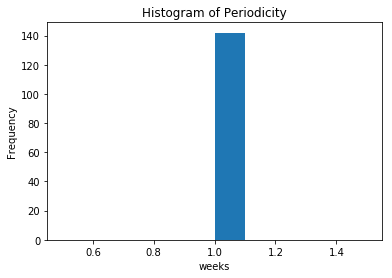

(Timedelta('7 days 00:00:00'), 'weeks')

In [11]:
ts.periodicity(show_plot=True)

* **Periodicity must be a constant value. If there are any anomalies, they can be found in the histogram**
* **Functionality to address anomalies in periodicity will be added in the next version**

** 4. Frequency of time series**

In [12]:
ts.frequency()

'W-MON'

** 5. Visualize time series of each category **
* Specify category (column) for visualization

In [13]:
# To download, run the code below
ts.visualize(category=category, download = True, folder_name=tracker.get_image_folder())

# To visualize right here, run the code below
ts.visualize(category = category)

Downloaded!


## 2. Ensemble model

**1. Understand how ensemble model and its wrapper class works**

* Split time series into train and validation sets
* Choose models to ensemble
* Compute weights of the chosen models 
* Evaluate the perfomance of ensemble model on validation set

**2. Choose a category and split its time series into train and validation sets**

In [14]:
%%skip $dont_test

# Train set
train = copy.deepcopy(ts)
train.data = pd.DataFrame(ts.data.iloc[:int(train_test_split*ts.data.shape[0])][category])

# Validation set
valid = copy.deepcopy(ts)
valid.data = pd.DataFrame(ts.data.iloc[int(train_test_split*ts.data.shape[0]):][category])

In [15]:
train.data.head()

Product        3      1
DC            26     41
2014-01-06  5438  21235
2014-01-13  6682  49917
2014-01-20  6157  16362
2014-01-27  6628  20694
2014-02-03  5895  12816

** 3. Choose models by instantiating their corresponding classes**

Documentation of parent packages of models
<br>[FbProphet](https://facebook.github.io/prophet/docs/quick_start.html)
<br>[AutoArima](https://github.com/tgsmith61591/pyramid/blob/master/examples/quick_start_example.ipynb)
<br>[stldecompose](https://github.com/jrmontag/STLDecompose/blob/master/STL%20usage%20example.ipynb)


**4. Find how to instantiate a model class**

In [16]:
%%skip $dont_test

#?NoodleProphet
#?NoodleAutoArima
#?NoodleSES
#?NoodleSTLF

**5. Set / change parameters of model**

In [17]:
%%skip $dont_test

pe = ParallelEnsemble(train, horizon=validation_horizon, period=validation_period, k=validation_sets, log_transform = log_transform)

**6. Instantiate the WeightedEnsemble class**

In [18]:
%%skip $dont_test

pe.initialize(models_ensemble)

**7. Get cv scores**

In [19]:
%%skip $dont_test

print(pe.cv_scores())

      metric   prophet      stlf       ses     arima     category
0  Unit MAPE   2.42947   3.74326   2.18221   2.43436  ('1', '41')
1   Mean ABS  0.247197  0.380876   0.22204  0.247695  ('1', '41')
2       RMSE  0.288181  0.442913  0.284343  0.316159  ('1', '41')
3  Unit MAPE   3.17484   3.53448   3.37656   3.04921  ('3', '26')
4   Mean ABS  0.274002   0.30504  0.291411  0.263159  ('3', '26')
5       RMSE  0.285401  0.349002  0.304586  0.272547  ('3', '26')


**8. Train the model**

In [20]:
%%skip $dont_test

pe.train()

**9. Get weights associated with each model**

In [21]:
%%skip $dont_test

print(pe.get_weights())

          (3, 26)   (1, 41)
arima    3.799987  4.037225
prophet  3.649615  4.045348
ses      3.431584  4.503703
stlf     3.278262  2.625530


In [22]:
valid_predictions = pe.predict(valid.data.shape[0])

**10. Evaluate the ensemble model using valid set**
* If accuracy is poor, tune the parameters of models in ensemble

In [23]:
%%skip $dont_test

print(pe.calculate_metrics(valid_predictions, valid.data))

               (3, 26)      (1, 41)
Mean ABS   2224.704126  5965.118187
RMSE       4100.025015  8813.614685
Unit MAPE    29.064985    25.328180


In [24]:
# To download, run the code below
pe.visualize(valid_predictions, valid.data, download = True, folder_name=tracker.get_image_folder())

# To visualize right here, run the code below
pe.visualize(valid_predictions, valid.data)

**11. Re-train models with entire data and compute weights to make future predictions**

In [25]:
ts_fut = copy.deepcopy(ts)
ts_fut.data = pd.DataFrame(ts_fut.data[category])

In [26]:
pe_fut = ParallelEnsemble(ts_fut, horizon=validation_horizon, period=validation_period, k=validation_sets)

In [27]:
pe_fut.initialize(models_ensemble)

In [28]:
pe_fut.train()

**12. Get weights associated with each model**

In [29]:
pe_fut.get_weights()

(3, 26)   (1, 41)
arima    0.000531  0.000119
prophet  0.000685  0.000133
ses      0.000446  0.000119
stlf     0.000635  0.000104

In [30]:
final_predictions = pe_fut.predict(pred_horizon=forecast_horizon)

In [31]:
# To download, run the code below
pe_fut.visualize(final_predictions, download = True, folder_name=tracker.get_image_folder())

# To visualize right here, run the code below
pe_fut.visualize(final_predictions)

## 3. Output dumps

In [32]:
tracker.set_output('future_model_weights',pe_fut.weight_df)
tracker.set_output('validation_cv_scores',pe_fut.predict_df)

In [33]:
%%skip $dont_test

tracker.set_output('future_model_weights',pe.cv_df)
tracker.set_output('validation_model_weights',pe.weight_df)
tracker.set_output('validation_metrics',pe.metrics_df)

In [34]:
tracker.close()

{'end_time': '05/07/2018 11:26:37',
 'exp_id': '62e089',
 'git_commit': '051048d8ee49a0db7cadfe1f5502e808b4ad8d9b',
 'input_params': '{"validation_horizon": "4", "validation_period": "2", "validation_sets": "2", "forecast_horizon": "52", "train_test_split": "0.8", "date_column": "Date", "value_column": "Order_Quantity", "id_field": "[\'Product\', \'DC\']", "filename": "../../data/product_data.csv", "observation_field": "{\'Product\': <class \'str\'>, \'DC\': <class \'str\'>}", "category": "[(\'3\', \'26\'), (\'1\', \'41\')]", "models_ensemble": "{\'prophet\': {\'growth\': \'linear\', \'changepoint_prior_scale\': 0.05}, \'stlf\': {}, \'ses\': {\'alpha\': 0.5}, \'autoarima\': {}}", "new_field": "5", "dont_test": "False", "log_transform": "True"}',
 'labels': '{}',
 'output_data': '["/tmp/62e089/data/future_model_weights.pkl", "/tmp/62e089/data/validation_cv_scores.pkl", "/tmp/62e089/data/future_model_weights.pkl", "/tmp/62e089/data/validation_model_weights.pkl", "/tmp/62e089/data/validat